In [2]:
import pandas as pd
import numpy as np
import cv2
import keras
import tensorflow as tf
import random

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, MaxPooling2D, Conv2D, Flatten, UpSampling2D, Reshape, Conv2DTranspose, Dropout 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

In [4]:

color_path = r'D:\DL\img_align_celeba'

color_images = []
gray_images = []
i=1

for image in os.listdir(color_path):
    rgb_img = cv2.cvtColor(cv2.imread(os.path.join(color_path, image)), cv2.COLOR_BGR2RGB)
    array_img = np.array(rgb_img[13:205, 9:169], dtype=float)
    resized_img = cv2.resize(array_img, (96,128))
    X = rgb2lab(1.0/255.0*resized_img)[:,:,0]/100
    Y = rgb2lab(1.0/255.0*resized_img)[:,:,1:]/128
    color_images.append(Y)
    gray_images.append(X)
    
    if i==10000:
        break
    i+=1
    

KeyboardInterrupt: 

In [3]:
color_tensor = np.array(color_images)
gray_tensor = np.expand_dims(np.array(gray_images), axis=-1)
print(color_tensor.shape)
print(gray_tensor.shape)


(10000, 128, 96, 2)
(10000, 128, 96, 1)


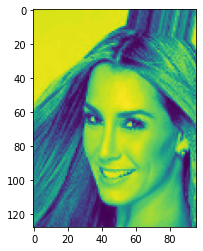

In [4]:
plt.imshow(gray_tensor[0])
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(gray_tensor, 
                                                  color_tensor, 
                                                  test_size=0.1, 
                                                  random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

print(f'There are {len(X_train)} images in training data')
print(f'There are {len(X_val)} images in validation data')
print(f'There are {len(X_test)} images in testing data')

There are 7200 images in training data
There are 1800 images in validation data
There are 1000 images in testing data


In [11]:
encoder_input = Input(shape=(128, 96, 1))
conv_down1 = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_input)
conv_down2 = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(conv_down1)
conv_down3 = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(conv_down2)
conv_down4 = Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(conv_down3)
encoder_output = Conv2D(512, (3, 3), activation='relu', strides=2, padding='same', name='dec_out')(conv_down4)

decoder_input = Conv2DTranspose(512, (3, 3), activation='relu', padding = 'same', strides=2)(encoder_output)
drop1 = Dropout(0.2)(decoder_input)
merge1 = keras.layers.concatenate([drop1, conv_down4])
conv_up1 = Conv2DTranspose (256, (3, 3), activation='relu', padding = 'same',strides=2)(merge1)
drop2 = Dropout(0.2)(conv_up1)
merge2 = keras.layers.concatenate([drop2, conv_down3])
conv_up2 = Conv2DTranspose (128, (3, 3), activation='relu', padding = 'same',strides=2)(merge2)
drop3 = Dropout(0.2)(conv_up2)
merge3 = keras.layers.concatenate([drop3, conv_down2])
conv_up3 = Conv2DTranspose (64, (3, 3), activation='relu', padding = 'same',strides=2)(merge3)
drop4 = Dropout(0.2)(conv_up3)
merge4 = keras.layers.concatenate([drop4, conv_down1])
conv_up4 = Conv2DTranspose (32, (3, 3), activation='relu', padding = 'same',strides=2)(merge4)
drop5 = Dropout(0.2)(conv_up4)
merge5 = keras.layers.concatenate([drop5, encoder_input])
decoder_output = Conv2D(2,(3,3), padding = 'same', strides=1)(merge5)

autoencoder = Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 96, 1)   0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 48, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 24, 64)   18496       conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 12, 128)  73856       conv2d_12[0][0]                  
________________________________________________________________________________________

In [12]:
EPOCHS = 50
BATCH =128

model_name = 'autoencoder_faces.h5'
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True)


history = autoencoder.fit(x=X_train,
                y=y_train, 
                validation_data=(X_val, y_val),
                epochs = EPOCHS, 
                batch_size = BATCH, 
                callbacks=[checkpoint])

Train on 7200 samples, validate on 1800 samples
Epoch 1/50
7200/7200 [==============================] - 69s 10ms/step - loss: 0.0111 - accuracy: 0.5876 - val_loss: 0.0075 - val_accuracy: 0.6317
Epoch 2/50


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


7200/7200 [==============================] - 62s 9ms/step - loss: 0.0077 - accuracy: 0.6143 - val_loss: 0.0071 - val_accuracy: 0.6327
Epoch 3/50
7200/7200 [==============================] - 62s 9ms/step - loss: 0.0074 - accuracy: 0.6177 - val_loss: 0.0069 - val_accuracy: 0.6322
Epoch 4/50
7200/7200 [==============================] - 63s 9ms/step - loss: 0.0072 - accuracy: 0.6185 - val_loss: 0.0068 - val_accuracy: 0.6377
Epoch 5/50
7200/7200 [==============================] - 63s 9ms/step - loss: 0.0071 - accuracy: 0.6234 - val_loss: 0.0068 - val_accuracy: 0.6082
Epoch 6/50
7200/7200 [==============================] - 63s 9ms/step - loss: 0.0070 - accuracy: 0.6211 - val_loss: 0.0067 - val_accuracy: 0.6291
Epoch 7/50
7200/7200 [==============================] - 63s 9ms/step - loss: 0.0069 - accuracy: 0.6242 - val_loss: 0.0065 - val_accuracy: 0.6313
Epoch 8/50
7200/7200 [==============================] - 63s 9ms/step - loss: 0.0068 - accuracy: 0.6279 - val_loss: 0.0065 - val_accuracy: 0.6

In [13]:
autoencoder.evaluate(X_test, y_test)

1000/1000 [==============================] - 3s 3ms/step


[0.007619526669383049, 0.642130434513092]

In [148]:
np.save('xtest_faces', X_test)
np.save('y_test_faces', y_test)

# Testing

In [7]:
X_test = np.load('xtest_faces.npy')
y_test = np.load('y_test_faces.npy')

autoencoder = keras.models.load_model('autoencoder_faces.h5')

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


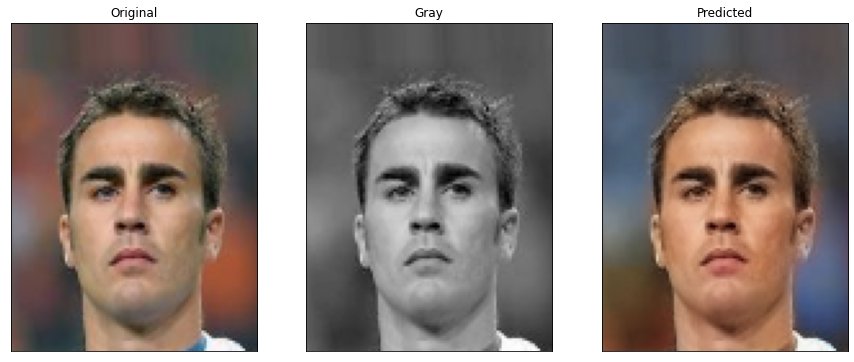

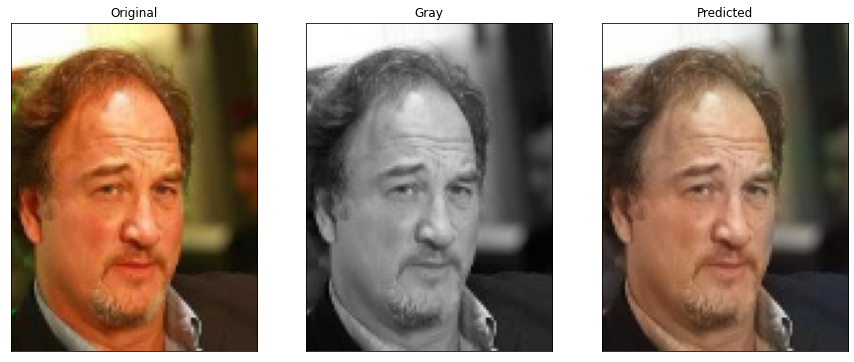

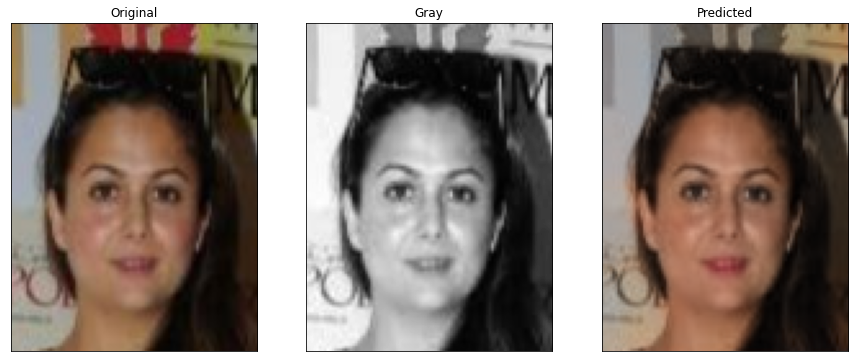

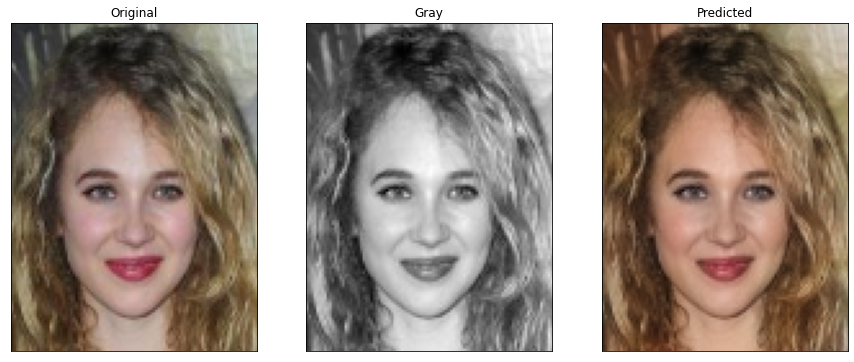

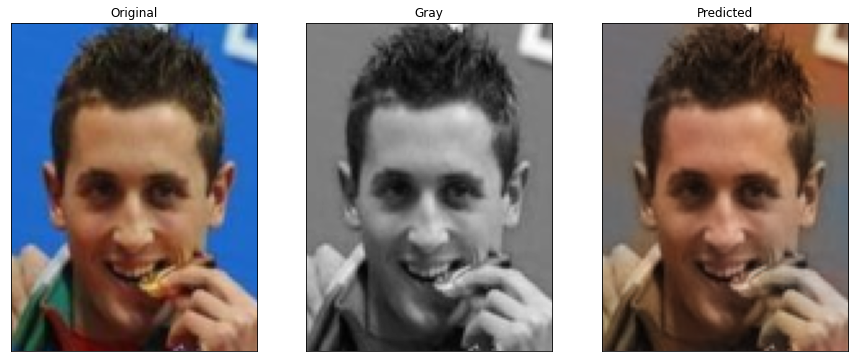

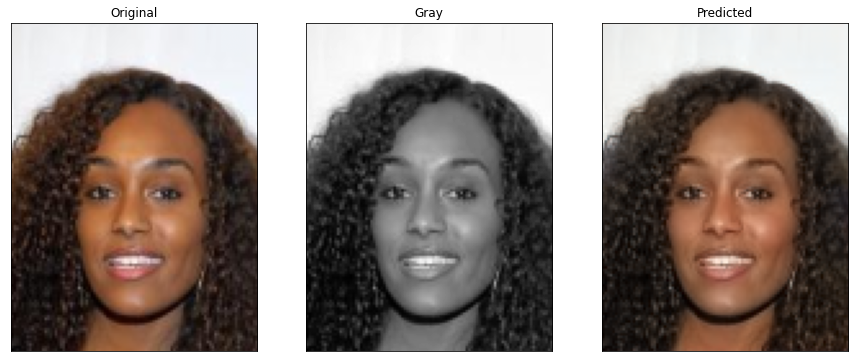

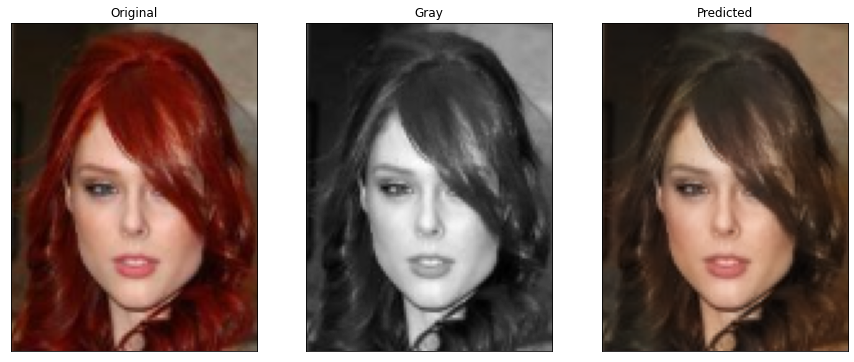

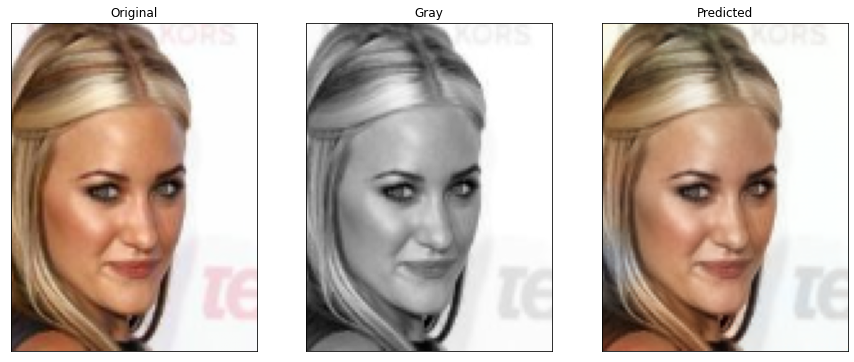

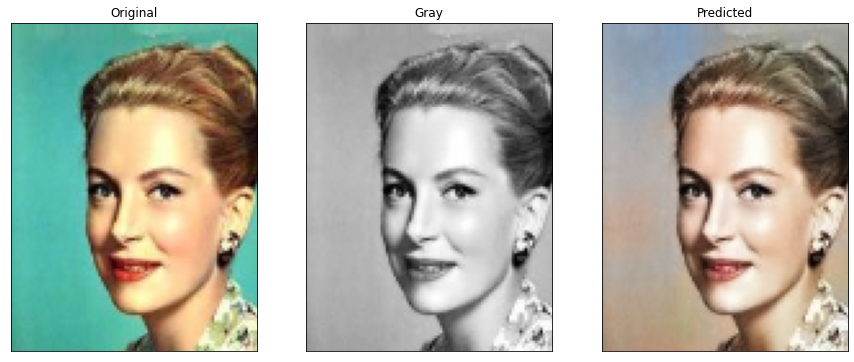

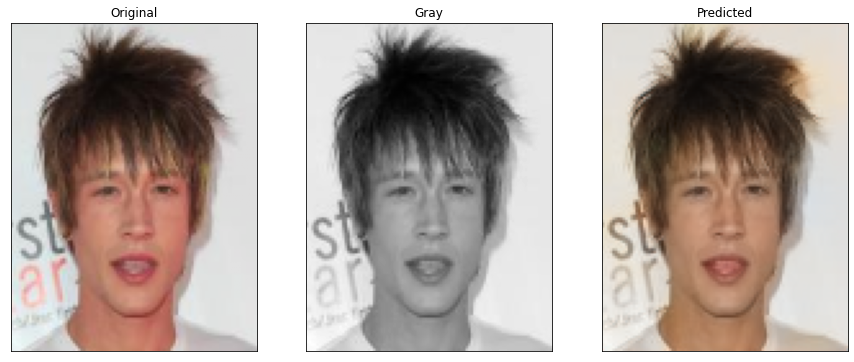

In [45]:
def show_images(original_image, predicted_image):
    plt.figure(figsize=(15,9))
    plt.subplot(1,3,1)
    plt.imshow(lab2rgb(original_image))
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(original_image[..., 0], cmap='gray')
    plt.title('Gray'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(lab2rgb(predicted_image))
    plt.title('Predicted'), plt.xticks([]), plt.yticks([])
    plt.show()

def make_lab_image(L, ab, number):
    empty_img = np.zeros((128, 96, 3))
    empty_img[:,:,0] = L[0][:,:,0]*100
    empty_img[:,:,1:] = ab[number]*128
    return empty_img

for i in range(10):
    num =  random.randint(0,len(X_test))
    image = X_test[num].reshape(1,128, 96,1)
    output = autoencoder.predict(image)

    original_img = make_lab_image(image, y_test, num)
    predicted_img = make_lab_image(image, output, 0)

    show_images(original_img, predicted_img)